# Deep Learning Assignment

Submitted by:
- Ronen Mashal
- Nir Schwartz

# Introduction

This notebook describes the progress and results of building a deep learning model to categorize the FASHION-MNIST images.
Throughout the project we've attempted to utilize the tools offered by W&B, so much of our effort was actually directed towards managing the environment, in order to complete the project assignment while developing a work methodology involving the W&B tools.

# Source code

The complete source code for the training and the application is placed on Github, here: https://github.com/ronenmashal/ml-p2
The W&B project is here: https://wandb.ai/ml-p2/ml-p2, containing:
- Dataset versions
- Model versions.
- Sweeps and runs.

# Connecting to W&B

Before we start with the dataset and model, we connect to W&B, in order to be able to load models and datasets.

In [3]:
!pip install wandb -qqq
import wandb
from datetime import datetime
wandb.login()

timestamp = datetime.now().strftime("%H%M%S")
run = wandb.init(project=f"ml-p2", entity="ml-p2")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rmashal (ml-p2). Use `wandb login --relogin` to force relogin


In [4]:
from collections import namedtuple
import numpy as np
import os
import tensorflow as tf

Dataset = namedtuple("Dataset", ["images", "labels"])
dataset_names = ["training", "validation", "test"]

def read_datasets(wandb_run, dataset_tag = "latest"):
    '''
    Read all datasets from W&B.
    Usage example: train_set, validation_set, test_set = wbh.read_datasets(run)
    '''
    artifact = wandb_run.use_artifact(f'ml-p2/ml-p2/fashion-mnist:{dataset_tag}', type='dataset')
    data_dir = artifact.download()
    return [ read_dataset(data_dir, ds_name) for ds_name in dataset_names ]

def read_dataset(data_dir, ds_name):
    filename = ds_name + ".npz"
    data = np.load(os.path.join(data_dir, filename))
    return Dataset(images = data["x"], labels = data["y"])

def read_model(wandb_run, model_name, model_tag = "latest") -> tf.keras.models.Model:
    artifact = wandb_run.use_artifact(f'ml-p2/ml-p2/{model_name}:{model_tag}', type='model')
    artifact_dir = artifact.download()
    return tf.keras.models.load_model(artifact_dir)


2022-07-19 17:18:34.158319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-19 17:18:34.158375: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# The Dataset

We loaded the fashion-mnist dataset, split it to train, validation and test sets, normalized the images (by dividing the pixel values by 255) and logged the datasets as a W&B project artifact, so it can be loaded as is later.

In [5]:
train_set, validation_set, test_set = read_datasets(run)

wandb: Downloading large artifact fashion-mnist:latest, 418.77MB. 3 files... Done. 0:0:0.0


# The Basic Model

We started with a very basic fully connected model as follows:

In [6]:
from tensorflow import keras

model = read_model(run, "FCNN", "v0")
model.summary()

2022-07-19 17:18:39.870168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-19 17:18:39.870223: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-19 17:18:39.870248: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hub3): /proc/driver/nvidia/version does not exist
2022-07-19 17:18:39.870546: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 200)               157000    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 60)                6060      
                                                                 
 dropout_2 (Dropout)         (None, 60)                0

The model offers several optimization points. We can change its behavior by:
1. Changing the `dropout_rate` of the Dropout layers.
2. Changing the size of each of the Dense layers (`l1_size`, `l2_size` and `l3_size`).
3. Changing the Dense layers activation method.

# First Training Attempt

We compiled the model with 'adam' optimizer and metrics 'accuracy'. We saved the trained model as 'v1'. Here are the results:

In [7]:
model = read_model(run, "FCNN", "v1")
model.evaluate(train_set.images, train_set.labels)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.2649 - accuracy: 0.8994


[0.26492154598236084, 0.89936363697052]

Well, seems like good results right off the top. So, we evaluated the model with the test set:

In [8]:
model.evaluate(test_set.images, test_set.labels)

313/313 [==============================] - 0s 2ms/step - loss: 0.3494 - accuracy: 0.8759


[0.34943079948425293, 0.8758999705314636]

Let's see the confusion matrix, to see where model fails:

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

predictions = model.predict(test_set.images)
y_test = np.argmax(predictions, axis = 1)
cr = classification_report(test_set.labels, y_test)
cm = confusion_matrix(test_set.labels, y_test)

In [10]:
print ("Classification Report:")
print (cr)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.75      0.82      0.78      1000
           3       0.84      0.90      0.87      1000
           4       0.73      0.84      0.78      1000
           5       0.99      0.95      0.97      1000
           6       0.74      0.61      0.67      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



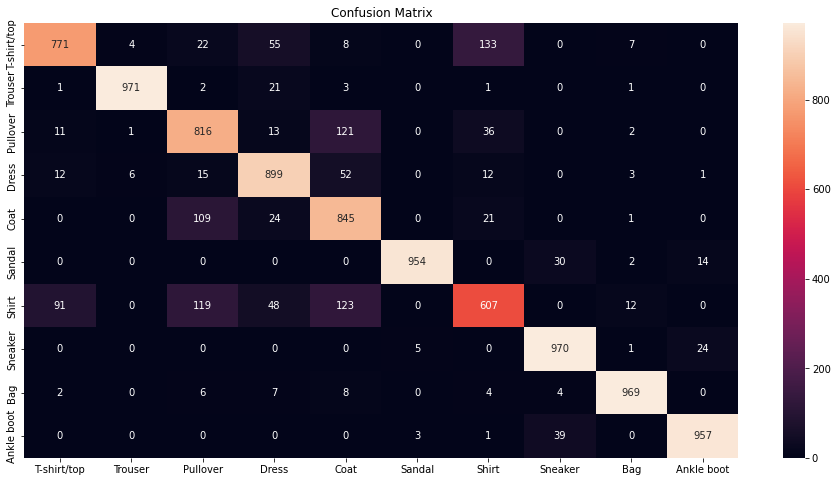

In [11]:
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

plt.subplots(1, 1, figsize = (16, 8))
ax = plt.subplot()
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
x = ax.xaxis.set_ticklabels(class_names)
y = ax.yaxis.set_ticklabels(class_names)


# Optimization Attempt

We tried to enhance the model's performance using W&B sweep. Here's a report of the sweep:

In [12]:
%wandb "ml-p2/ml-p2/reports/First-Optimization-Attempt--VmlldzoyMzI1NzY1"

From the report we can see that the sweep was not able to achieve much improvement in the model's performance. The model's validation accuracy remains around 0.9 and validation loss around 0.3.

However, we do see that the prefered activation method is indeed 'relu', compared to the other methods chosen for the sweep.

# Adding a layer

We tried to enhance the model performance by adding another Dense layer.
Also, we changed the sweep configuration to allow larger layer sizes.
Following is the summary of the sweep on 4 layers:

In [13]:
%wandb "ml-p2/ml-p2/reports/Sweeping-on-4-Layers--VmlldzoyMzM5MjU4"

The summary shows that even by adding a layer and increasing the layer sizes to 600 nodes, we still cannot achieve better results.

We moved on, trying to enhance the inference performance, by changing the model to use convolution.

# Convolution model

We changed the model to be as follows:

In [14]:
model = read_model(run, "Conv1", "v0")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 100)               1254500   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                        

The performance of the model:

In [15]:
model.evaluate(train_set.images, train_set.labels)

1719/1719 [==============================] - 13s 8ms/step - loss: 0.0676 - accuracy: 0.9759


[0.06763877719640732, 0.9759091138839722]

In [16]:
model.evaluate(test_set.images, test_set.labels)

313/313 [==============================] - 2s 8ms/step - loss: 0.3160 - accuracy: 0.9079


[0.31598496437072754, 0.9078999757766724]

In [17]:
predictions = model.predict(test_set.images)
y_test = np.argmax(predictions, axis = 1)
cr_conv = classification_report(test_set.labels, y_test)
cm_conv = confusion_matrix(test_set.labels, y_test)

In [18]:
print ("Classification Report:")
print (cr_conv)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.86      0.82      0.84      1000
           3       0.92      0.91      0.91      1000
           4       0.87      0.84      0.86      1000
           5       0.98      0.99      0.98      1000
           6       0.71      0.78      0.74      1000
           7       0.99      0.94      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.95      0.98      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



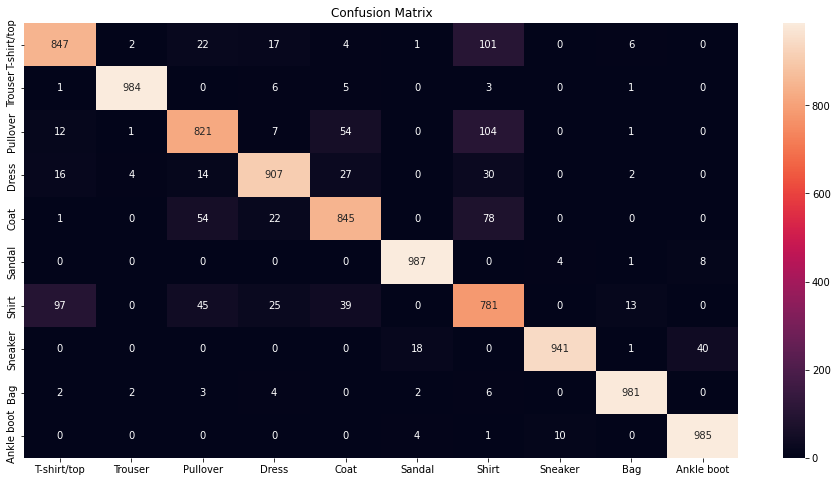

In [19]:
plt.subplots(1, 1, figsize = (16, 8))
ax = plt.subplot()
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
sns.heatmap(cm_conv, annot=True, fmt='g', ax=ax)
x = ax.xaxis.set_ticklabels(class_names)
y = ax.yaxis.set_ticklabels(class_names)

The model achieved immediate performance improvement, though not as much as we wanted on the test set.
From the high training accuracy and relatively low test accuracy, we estimate that the model acieved overfitting on the training data.

# Optimizing the Convolution Model

We used a sweep to attemp tuning the convolution model.

In [20]:
%wandb "ml-p2/ml-p2/reports/CNN-Model-Optimization--VmlldzoyMzQwODQy"

In [21]:
# Get the best model from the sweep.
api = wandb.Api()

sweep = api.sweep("ml-p2/ml-p2/6zmewzd0")
runs = sorted(sweep.runs,
  key=lambda run: run.summary.get("val_accuracy", 0), reverse=True)
val_acc = runs[0].summary.get("val_accuracy", 0)
print(f"Best run {runs[0].name} with {val_acc} validation accuracy")

model_file = runs[0].file("model-best.h5").download(replace=True)
model_file.close()

Best run Conv-142858 with 0.9169999957084656 validation accuracy


In [22]:
best_model = keras.models.load_model(".\\model-best.h5")

OSError: No file or directory found at .\model-best.h5

In [ ]:
best_model.summary()

In [ ]:
model.evaluate(train_set.images, train_set.labels)

In [ ]:
model.evaluate(test_set.images, test_set.labels)

# Conclusion

The rigorous training with the W&B sweep did not make a significant enhancement in the performance in both cases - FCNN and CNN models.
We could also try data augmentation, bigger and more complex networks, but unfortunately, we do not have the time to complete this.

# Reflection

What have we learned from this project? 
__Managing an ML project is so much different from what we know about software projects.__
  - You have to maintain the training source code versions separately from the application source code. They're not tightly coupled.  
  - You have to maintain dataset and model versions.
  - Then you have to connect them all together in a meaningful way...
  
Also, we saw that working in a group on ML projects requires much more coordination (and experience) than when working together on standard software projects.

These were our main challenges (other than learning the tools) during the project.